**Lectura del conjunto de datos CIFAR-10**

In [1]:
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import tensorflow_datasets as tfds
train_data, test_data = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)

2023-10-23 15:51:20.150188: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-23 15:51:20.150254: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-23 15:51:20.152800: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-23 15:51:20.310895: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-23 15:51:21.817936: W tensorflow/compiler/

**Preproceso de las imágenes**

In [19]:
img_size = (299, 299)
num_classes = 10

def preprocess(image, label):
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)
    label = tf.one_hot(label, num_classes)
    return image, label

train_data = train_data.map(preprocess)
test_data = test_data.map(preprocess)

**Realizamos la partición entrenamiento/validación (80%/20%)**

In [20]:
train_size = int(0.8 * 50000)

train_dataset = train_data.take(train_size)
val_dataset = train_data.skip(train_size)

**Leemos el modelo InceptionV3 pre-entrenado con imagenet**

El modelo se lee sin la (última) capa 'softmax' (include_top=False)

In [21]:
M = InceptionV3(input_shape=img_size + (3,),include_top=False, weights='imagenet')

**Se congelan las capas pre-entrenadas para no modificar estos parámetros durante el fine-tuning**

In [22]:
for layer in M.layers:
    layer.trainable = False

**Se añaden algunas nuevas capas entre ellas la (última) capa 'softmax' ajustada al número de clases de la tarea (10)**

In [23]:
from tensorflow import keras
num_classes=10
x = keras.layers.GlobalAveragePooling2D()(M.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
output = keras.layers.Dense(num_classes, activation='softmax')(x)

**Se construye el modelo uniendo las capas pre-entrenadas (input) con las nuevas capas (output)**

In [24]:
M = keras.models.Model(inputs=M.input, outputs=output)

**Se compila el modelo definiendo algunos de sus parámetros (optimizador, pérdida y métrica)**

In [25]:
M.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

**Se realiza el fine-tuning**

In [26]:
batch_size = 32
epochs = 10
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
H = M.fit(train_dataset, epochs=epochs, validation_data=val_dataset, verbose=1)

Epoch 1/10
1250/1250 [==============================] - 254s 199ms/step - loss: 0.5981 - accuracy: 0.8017 - val_loss: 0.4093 - val_accuracy: 0.8611
Epoch 2/10
1250/1250 [==============================] - 242s 194ms/step - loss: 0.4766 - accuracy: 0.8400 - val_loss: 0.4078 - val_accuracy: 0.8620
Epoch 3/10
1250/1250 [==============================] - 243s 194ms/step - loss: 0.4439 - accuracy: 0.8494 - val_loss: 0.3851 - val_accuracy: 0.8700
Epoch 4/10
1250/1250 [==============================] - 243s 194ms/step - loss: 0.4182 - accuracy: 0.8569 - val_loss: 0.3735 - val_accuracy: 0.8750
Epoch 5/10
1250/1250 [==============================] - 250s 200ms/step - loss: 0.4006 - accuracy: 0.8615 - val_loss: 0.3854 - val_accuracy: 0.8726
Epoch 6/10
1250/1250 [==============================] - 243s 195ms/step - loss: 0.3807 - accuracy: 0.8683 - val_loss: 0.3749 - val_accuracy: 0.8752
Epoch 7/10
1250/1250 [==============================] - 244s 195ms/step - loss: 0.3662 - accuracy: 0.8742 - val_

**Representamos gráficamente la evolución del fine-tuning (loss y accuracy)**

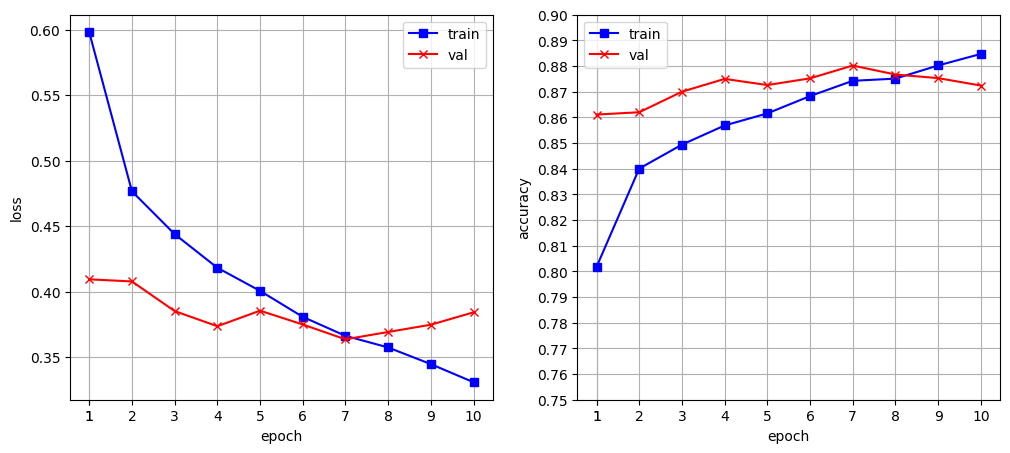

In [27]:
import numpy as np
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
xx = np.arange(1, len(H.history['loss'])+1)
xticks = np.concatenate((np.array([1]), np.arange(1, len(H.history['loss'])+1, 1)))
ax = axes[0]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('loss');
ax.set_xticks(xticks)
ax.plot(xx, H.history['loss'], color='b', marker='s', label='train')
ax.plot(xx, H.history['val_loss'], color='r', marker='x', label='val'); ax.legend()
ax = axes[1]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.set_xticks(xticks); ax.set_yticks(np.arange(.75, 0.90, .01)); ax.set_ylim([.75, 0.9])
ax.plot(xx, H.history['accuracy'], color='b', marker='s', label='train')
ax.plot(xx, H.history['val_accuracy'], color='r', marker='x', label='val'); ax.legend();